In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from sklearn.svm import SVC

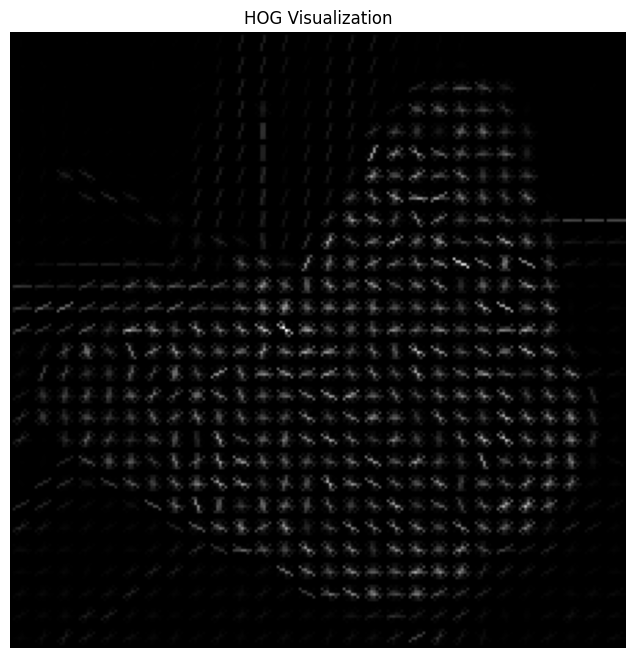

In [8]:
from skimage import io, color
from skimage.feature import hog
# Load image
#image = io.imread("NASA_Astronaut_Group_18.jpg")
image = io.imread("image_1007.jpg")

# Convert to grayscale (HOG works on single channel)
gray = color.rgb2gray(image)

# Compute HOG and visualization
features, hog_image = hog(
    gray,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    visualize=True
)

# Display
plt.figure(figsize=(8, 8))
plt.imshow(hog_image, cmap='gray')
plt.axis('off')
plt.title("HOG Visualization")
plt.show()


In [4]:
features

array([0.21805598, 0.04238033, 0.12570306, ..., 0.19126952, 0.24447853,
       0.23032158], shape=(86436,))

In [5]:
hog_image

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00057192, ..., 0.00414018, 0.        ,
        0.        ],
       [0.        , 0.00113477, 0.        , ..., 0.        , 0.00203101,
        0.        ],
       ...,
       [0.        , 0.00335689, 0.        , ..., 0.        , 0.01142484,
        0.        ],
       [0.        , 0.        , 0.00123909, ..., 0.00645207, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(400, 400))